In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from sklearn.metrics import roc_auc_score,precision_recall_curve,roc_curve
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, auc
from sklearn import model_selection

In [ ]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold, KFold
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import lightgbm as lgb

In [ ]:
def evalBinaryClassifier(model, x, y, labels=['Positives','Negatives']):
    '''
    source: https://towardsdatascience.com/how-to-interpret-a-binary-logistic-regressor-with-scikit-learn-6d56c5783b49
    Visualize the performance of  a Logistic Regression Binary Classifier.

    Displays a labelled Confusion Matrix, distributions of the predicted
    probabilities for both classes, the ROC curve, and F1 score of a fitted
    Binary Logistic Classifier. Author: gregcondit.com/articles/logr-charts
    Parameters
    ----------
    model : fitted scikit-learn model with predict_proba & predict methods
        and classes_ attribute. Typically LogisticRegression or
        LogisticRegressionCV

    x : {array-like, sparse matrix}, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples
        in the data to be tested, and n_features is the number of features

    y : array-like, shape (n_samples,)
        Target vector relative to x.
        labels: list, optional
        list of text labels for the two classes, with the positive label first

    Displays
    ----------
    3 Subplots

    Returns
    ----------
    F1: float
    '''
    #model predicts probabilities of positive class
    p = model.predict_proba(x)
    if len(model.classes_)!=2:
        raise ValueError('A binary class problem is required')
    if model.classes_[1] == 1:
        pos_p = p[:,1]
    elif model.classes_[0] == 1:
        pos_p = p[:,0]

    #FIGURE
    plt.figure(figsize=[15,4])

    #1 -- Confusion matrix
    cm = confusion_matrix(y,model.predict(x))
    plt.subplot(131)
    ax = sns.heatmap(cm, annot=True, cmap='Blues', cbar=False,
                annot_kws={"size": 14}, fmt='g')
    cmlabels = ['True Negatives', 'False Positives',
              'False Negatives', 'True Positives']
    for i,t in enumerate(ax.texts):
      t.set_text(t.get_text() + "\n" + cmlabels[i])
    plt.title('Confusion Matrix', size=15)
    plt.xlabel('Predicted Values', size=13)
    plt.ylabel('True Values', size=13)

    #2 -- Distributions of Predicted Probabilities of both classes
    df = pd.DataFrame({'probPos':pos_p, 'target': y})
    plt.subplot(132)
    plt.hist(df[df.target==1].probPos, density=True, bins=25,
             alpha=.5, color='green',  label=labels[0])
    plt.hist(df[df.target==0].probPos, density=True, bins=25,
             alpha=.5, color='red', label=labels[1])
    plt.axvline(.5, color='blue', linestyle='--', label='Boundary')
    plt.xlim([0,1])
    plt.title('Distributions of Predictions', size=15)
    plt.xlabel('Positive Probability (predicted)', size=13)
    plt.ylabel('Samples (normalized scale)', size=13)
    plt.legend(loc="upper right")

    #3 -- ROC curve with annotated decision point
    fp_rates, tp_rates, _ = roc_curve(y,p[:,1])
    roc_auc = auc(fp_rates, tp_rates)
    plt.subplot(133)
    plt.plot(fp_rates, tp_rates, color='green',
             lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], lw=1, linestyle='--', color='grey')
    #plot current decision point:
    tn, fp, fn, tp = [i for i in cm.ravel()]
    plt.plot(fp/(fp+tn), tp/(tp+fn), 'bo', markersize=8, label='Decision Point')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', size=13)
    plt.ylabel('True Positive Rate', size=13)
    plt.title('ROC Curve', size=15)
    plt.legend(loc="lower right")
    plt.subplots_adjust(wspace=.3)
    plt.show()
    #Print and Return the F1 score
    tn, fp, fn, tp = [i for i in cm.ravel()]
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    F1 = 2*(precision * recall) / (precision + recall)
    printout = (
        f'Precision: {round(precision,2)} | '
        f'Recall: {round(recall,2)} | '
        f'F1 Score: {round(F1,2)} | '
    )
    print(printout)
    return F1

In [ ]:
import pandas as pd
train = pd.read_csv('cs-training.csv')
test = pd.read_csv('cs-test.csv')

In [ ]:
print('train shape  ',train.shape)

train shape   (150000, 12)


In [ ]:
train.dtypes.value_counts()

int64      8
float64    4
dtype: int64

In [ ]:
train.info()
#print(train)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 12 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   Unnamed: 0                            150000 non-null  int64  
 1   SeriousDlqin2yrs                      150000 non-null  int64  
 2   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 3   age                                   150000 non-null  int64  
 4   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 5   DebtRatio                             150000 non-null  float64
 6   MonthlyIncome                         120269 non-null  float64
 7   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 8   NumberOfTimes90DaysLate               150000 non-null  int64  
 9   NumberRealEstateLoansOrLines          150000 non-null  int64  
 10  NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 11  

In [ ]:
train = train.dropna()

train = train.drop(columns = ['Unnamed: 0'])
#train['binary_income'] = 0
#med = train['MonthlyIncome'].median()


#med = train['MonthlyIncome'].median()

#med_['binary_income'] = 0
#print(med_)
#med_ =

print(train.head())
#print(train.shape)


   SeriousDlqin2yrs  RevolvingUtilizationOfUnsecuredLines  age  \
0                 1                              0.766127   45   
1                 0                              0.957151   40   
2                 0                              0.658180   38   
3                 0                              0.233810   30   
4                 0                              0.907239   49   

   NumberOfTime30-59DaysPastDueNotWorse  DebtRatio  MonthlyIncome  \
0                                     2   0.802982         9120.0   
1                                     0   0.121876         2600.0   
2                                     1   0.085113         3042.0   
3                                     0   0.036050         3300.0   
4                                     1   0.024926        63588.0   

   NumberOfOpenCreditLinesAndLoans  NumberOfTimes90DaysLate  \
0                               13                        0   
1                                4                        0   

In [ ]:
import numpy as np
features = train.columns.values[0:30]
#print(features)
unique_max_train = []
unique_max_test = []
for feature in features:
    values = train[feature].value_counts()
    unique_max_train.append([feature, values.max(), values.idxmax()])

np.transpose((pd.DataFrame(unique_max_train, columns=['Feature', 'Max duplicates', 'Value'])).\
            sort_values(by = 'Max duplicates', ascending=False).head(15))
#print(train[train['NumberOfDependents']== 20.0])
#print(values)

,9,7,0,3,10,8,6,1,2,5,4
Feature,NumberOfTime60-89DaysPastDueNotWorse,NumberOfTimes90DaysLate,SeriousDlqin2yrs,NumberOfTime30-59DaysPastDueNotWorse,NumberOfDependents,NumberRealEstateLoansOrLines,NumberOfOpenCreditLinesAndLoans,RevolvingUtilizationOfUnsecuredLines,age,MonthlyIncome,DebtRatio
Max duplicates,113994,113544,111912,99970,65456,43430,10810,7871,3217,2757,2491
Value,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,49.0,5000.0,0.0


In [ ]:
train.SeriousDlqin2yrs.value_counts()

0    111912
1      8357
Name: SeriousDlqin2yrs, dtype: int64

In [ ]:
train_X = train.drop(["SeriousDlqin2yrs"], axis=1)
train_y = np.log1p(train["SeriousDlqin2yrs"].values)
print(train_y)
#train['MonthlyIncome'].fillna(train['MonthlyIncome'].median(), inplace=True)
"""print(train['MonthlyIncome'].median())
print(train['MonthlyIncome'].mean())
med = train['MonthlyIncome'].median()
med_ = train[train['MonthlyIncome'] <= med]
med1 = train[train['MonthlyIncome'] > med]
print(med_.shape)
print(med1.shape)"""

[0.69314718 0.         0.         ... 0.         0.         0.        ]


"print(train['MonthlyIncome'].median())\nprint(train['MonthlyIncome'].mean())\nmed = train['MonthlyIncome'].median()\nmed_ = train[train['MonthlyIncome'] <= med] \nmed1 = train[train['MonthlyIncome'] > med] \nprint(med_.shape) \nprint(med1.shape)"

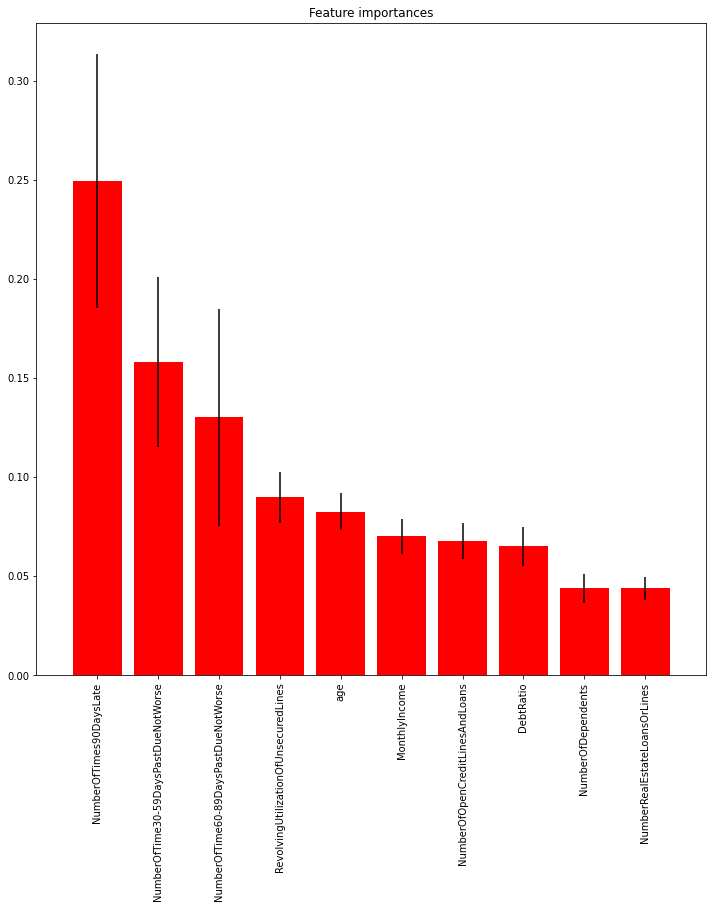

In [ ]:
from sklearn import ensemble
model = ensemble.ExtraTreesRegressor(n_estimators=200, max_depth=20, max_features=0.5, n_jobs=-1, random_state=0)
model.fit(train_X, train_y)

## plotando as importâncias ##
feat_names = train_X.columns.values
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
indices = np.argsort(importances)[::-1][:20]

plt.figure(figsize=(12,12))
plt.title("Feature importances")
plt.bar(range(len(indices)), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical')
plt.xlim([-1, len(indices)])
plt.show()

In [ ]:
def plot_roc(y_test,prob):
    fpr, tpr, thresholds = roc_curve(y_test, probs)
    # plot no skill
    plt.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    plt.plot(fpr, tpr, marker='.')
    plt.title("ROC curve")
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')
    # show the plot
    plt.show()

In [ ]:
def logistic(X,y):
    y_train=train['SeriousDlqin2yrs'].astype('uint8')
    X_train,X_test,y_train,y_test=train_test_split(train.drop('SeriousDlqin2yrs',axis=1),y_train,test_size=.2,random_state=2020)
    lr=LogisticRegression()
    lr.fit(X_train,y_train)
    prob=lr.predict_proba(X_test)

    roc=roc_auc_score(y_test, lr.predict_proba(X_test)[:,1])
    print('roc ',roc)
    print('lr', lr.fit(X_train,y_train))
    #print('X_train', X_train)

    print('X_Test', X_test)
    print('prob', prob)
    #print('prob', prob[:,1])"""
    print('y_train', y_train)

    return (prob[:,1],y_test)
y_train=train['SeriousDlqin2yrs'].astype('uint8')
probs,y_test=logistic(train.drop('SeriousDlqin2yrs',axis=1),y_train)
print('test',y_test)
#print(y_train)
#print(train['SeriousDlqin2yrs'])

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


roc  0.6662572612580925
lr LogisticRegression()
X_Test         RevolvingUtilizationOfUnsecuredLines  age  \
50049                               0.000000   77   
73150                               0.087512   70   
32901                               0.200307   66   
57364                               0.691417   38   
148096                              0.019646   27   
...                                      ...  ...   
4245                                0.179039   61   
77263                               0.718208   39   
104475                              0.048748   63   
59890                               0.245824   50   
95926                               0.000000   54   

        NumberOfTime30-59DaysPastDueNotWorse  DebtRatio  MonthlyIncome  \
50049                                      0   0.000000         1510.0   
73150                                      0   0.399546         4842.0   
32901                                      0   0.279738        43000.0   
57364       

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[0.00000000e+00 0.00000000e+00 4.46967327e-05 ... 9.98614401e-01
 9.98614401e-01 1.00000000e+00]
[0.00000000e+00 5.94883998e-04 5.94883998e-04 ... 9.99405116e-01
 1.00000000e+00 1.00000000e+00]


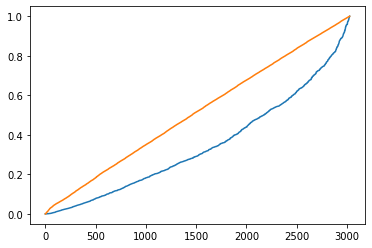

In [ ]:
"""print(probs)
print(y_train.head(15))
print(train)"""
#print(train.drop('SeriousDlqin2yrs',axis=1))
#print(roc_curve(y_test,probs))
fpr1, tpr1, thresholds1 = roc_curve(y_test,probs)
print(fpr1)
print(tpr1)
plt.plot(fpr1)
plt.plot(tpr1)
#plt.plot(fpr1, tpr1)

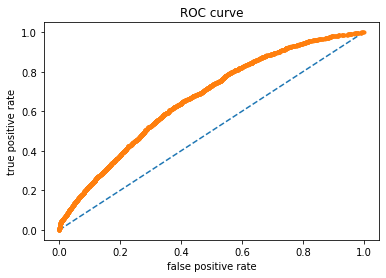

In [ ]:
plot_roc(y_test,probs)

In [ ]:
train_x, val_x, train_y, val_y=train_test_split(train.drop('SeriousDlqin2yrs',axis=1),y_train,test_size=.2,random_state=2020)
print(y_train)
clf = LogisticRegression(solver="lbfgs").fit(train_x, train_y)
pred_y = clf.predict(val_x)
#print('x',train_x)
#print('y',train_y)
print('u', val_y)
#print(clf)
print('pred', pred_y)
#print(val_x)

0         1
1         0
2         0
3         0
4         0
         ..
149994    0
149995    0
149996    0
149998    0
149999    0
Name: SeriousDlqin2yrs, Length: 120269, dtype: uint8
u 50049     0
73150     0
32901     0
57364     0
148096    0
         ..
4245      0
77263     0
104475    0
59890     0
95926     0
Name: SeriousDlqin2yrs, Length: 24054, dtype: uint8
pred [0 0 0 ... 0 0 0]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [ ]:
rocrl=roc_auc_score(val_y, pred_y)
rocrl

0.5041934495861404

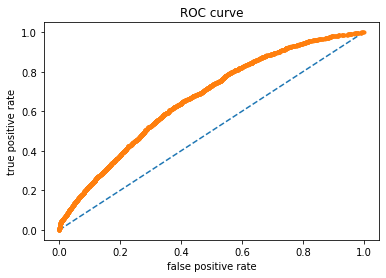

[0 0 0 ... 0 0 0]


In [ ]:
plot_roc(val_y, pred_y)
#print(val_y)
print(pred_y)

In [ ]:
%%time
model = RandomForestClassifier(n_estimators=220).fit(train_x,train_y)
predictionforest = model.predict(val_x)

CPU times: user 50.6 s, sys: 200 ms, total: 50.8 s
Wall time: 50.7 s


In [ ]:
%%time
rocrf=roc_auc_score(val_y, predictionforest)
print('roc ',rocrf)

roc  0.5864789246130975
CPU times: user 9.18 ms, sys: 1 ms, total: 10.2 ms
Wall time: 14.9 ms


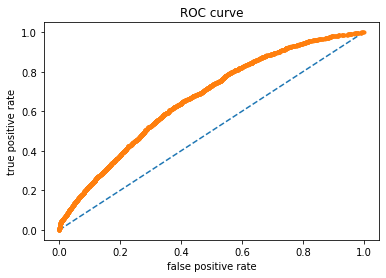

In [ ]:
plot_roc(val_y, predictionforest)

In [ ]:
xgb_cfl = xgb.XGBClassifier(n_jobs = -1,
                            n_estimators = 220)

xgb_cfl.fit(train_x, train_y)
y_scorexgb = xgb_cfl.predict_proba(val_x)[:,1]

In [ ]:
rocxgb=roc_auc_score(val_y, y_scorexgb)
print('roc ',rocxgb)

roc  0.8649623562309385


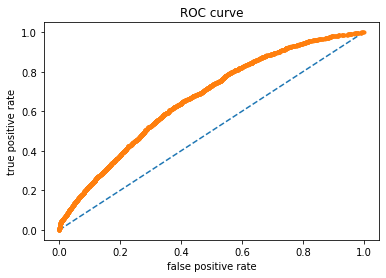

In [ ]:
plot_roc(val_y, y_scorexgb)


In [ ]:
xgb_cfl = xgb.XGBClassifier(n_jobs = -1)
xgb_cfl.fit(train_x, train_y)
y_pred = xgb_cfl.predict(val_x)
y_score = xgb_cfl.predict_proba(val_x)[:,1]

In [ ]:
%%time
param_grid = {
            'n_estimators': [50, 100, 200]
              }

CV_xgb_cfl = GridSearchCV(estimator = xgb_cfl, param_grid = param_grid, scoring ='roc_auc', verbose = 2)
CV_xgb_cfl.fit(train_x, train_y)

best_parameters = CV_xgb_cfl.best_params_
print("The best parameters: ", best_parameters)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] END ....................................n_estimators=50; total time=   2.1s
[CV] END ....................................n_estimators=50; total time=   2.0s
[CV] END ....................................n_estimators=50; total time=   2.0s
[CV] END ....................................n_estimators=50; total time=   2.0s
[CV] END ....................................n_estimators=50; total time=   2.0s
[CV] END ...................................n_estimators=100; total time=   3.9s
[CV] END ...................................n_estimators=100; total time=   3.9s
[CV] END ...................................n_estimators=100; total time=   3.9s
[CV] END ...................................n_estimators=100; total time=   3.9s
[CV] END ...................................n_estimators=100; total time=   4.7s
[CV] END ...................................n_estimators=200; total time=   7.7s
[CV] END ...................................n_est

In [ ]:
xgb_cfl2 = xgb.XGBClassifier(n_jobs = -1,
                            n_estimators = 120)

xgb_cfl2.fit(train_x, train_y)
y_score2 = xgb_cfl2.predict_proba(val_x)[:,1]

In [ ]:
rocxgb=roc_auc_score(val_y, y_score2)
print('roc ',rocxgb)

roc  0.8650872730959465


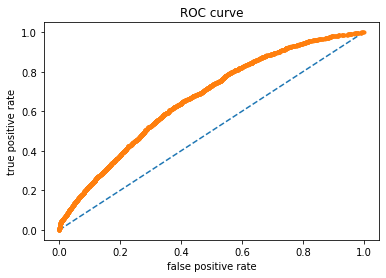

In [ ]:
plot_roc(val_y, y_score2)

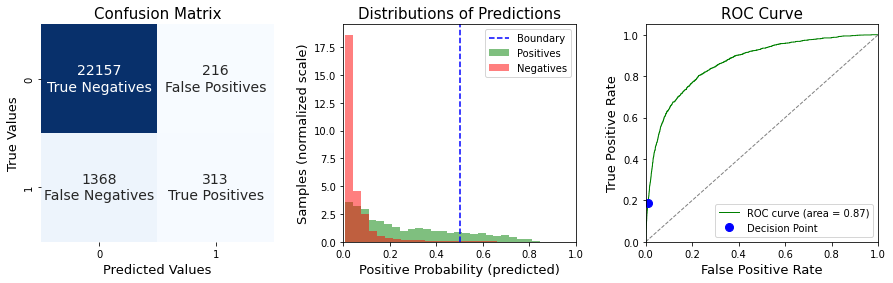

Precision: 0.59 | Recall: 0.19 | F1 Score: 0.28 | 


In [ ]:
F1 = evalBinaryClassifier(xgb_cfl2, val_x, val_y)

        Target  Probability
50049        0     0.007921
73150        0     0.009644
32901        0     0.018744
57364        0     0.165411
148096       0     0.022174
...        ...          ...
4245         0     0.019445
77263        0     0.062495
104475       0     0.008783
59890        0     0.022072
95926        0     0.014940

[24054 rows x 2 columns]
        Target  Probability
94799        1     0.151564
36732        1     0.119717
26860        1     0.305123
10515        1     0.266357
27872        1     0.062084
...        ...          ...
110140       1     0.475414
106141       1     0.013032
147380       1     0.087999
4757         1     0.044644
90604        1     0.436363

[1681 rows x 2 columns]
count    1681.000000
mean        0.267269
std         0.217003
min         0.007160
25%         0.080286
50%         0.201778
75%         0.420265
max         0.846330
Name: Probability, dtype: float64


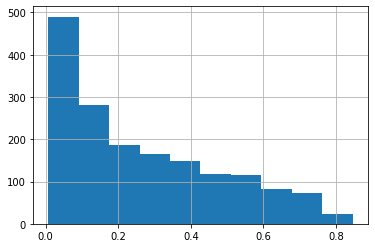

In [ ]:
## Target 1
target1 = pd.DataFrame({"Target": val_y, 'Probability': y_score2 })
print(target1)
print(target1.loc[target1.Target == 1])
print(target1.loc[target1.Target == 1, 'Probability'].describe())
target1.loc[target1.Target == 1, 'Probability'].hist()

In [ ]:
test=test.drop(["SeriousDlqin2yrs","Unnamed: 0"],1)
print(test)

        RevolvingUtilizationOfUnsecuredLines  age  \
0                                   0.885519   43   
1                                   0.463295   57   
2                                   0.043275   59   
3                                   0.280308   38   
4                                   1.000000   27   
...                                      ...  ...   
101498                              0.282653   24   
101499                              0.922156   36   
101500                              0.081596   70   
101501                              0.335457   56   
101502                              0.441842   29   

        NumberOfTime30-59DaysPastDueNotWorse    DebtRatio  MonthlyIncome  \
0                                          0     0.177513         5700.0   
1                                          0     0.527237         9141.0   
2                                          0     0.687648         5083.0   
3                                          1     0.925961  

In [ ]:
sampleEntry = pd.read_csv('sampleEntry.csv')
#xgb_cfl2.predict_proba(test))
res = xgb_cfl2.predict_proba(test)[:,1]
sampleEntry["Probability"]=res
sampleEntry.max()
print(sampleEntry)

            Id  Probability
0            1     0.070422
1            2     0.047023
2            3     0.017491
3            4     0.078876
4            5     0.096590
...        ...          ...
101498  101499     0.031266
101499  101500     0.339346
101500  101501     0.007994
101501  101502     0.054424
101502  101503     0.045564

[101503 rows x 2 columns]


In [ ]:
sampleEntry.to_csv("submission.csv",index=False)

In [ ]:
from platform import python_version
print(python_version())

3.7.13


In [ ]:
test.describe()

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,101503.000000,101503.000000,101503.000000,101503.000000,8.140000e+04,101503.000000,101503.000000,101503.000000,101503.000000,98877.000000
mean,5.310000,52.405436,0.453770,344.475020,6.855036e+03,8.453514,0.296691,1.013074,0.270317,0.769046
std,196.156039,14.779756,4.538487,1632.595231,3.650860e+04,5.144100,4.515859,1.110253,4.503578,1.136778
min,0.000000,21.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.030131,41.000000,0.000000,0.173423,3.408000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.152586,52.000000,0.000000,0.364260,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.564225,63.000000,0.000000,0.851619,8.200000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,21821.000000,104.000000,98.000000,268326.000000,7.727000e+06,85.000000,98.000000,37.000000,98.000000,43.000000
